# Exercise 7 - Solution

## Steps
1. Get necessary data and inspect data and data structure.
2. Get information for area definition and create it.
3. Load the data
    - Create MultiScene from all files
    - Resample MultiScene to area definition
    - Blend the MultiScene to a timeseries
4. Calculate Cloud mask for each time slot using 10.8, 3.9 band difference and researched threshold value
5. Calculate monthly frequencies
6. Visualize and analyse results

In [1]:
from satpy import Scene, MultiScene
from satpy.multiscene import timeseries
from pyresample.geometry import AreaDefinition
from pathlib import Path
from itertools import chain

from dask.distributed import Client

client = Client(processes=False) 
client

### Create area definition

In [3]:
area_id = 'Dem. Rep. Kongo'
description = 'Dem. Rep. Kongo in Lambert Azimuthal Equal Area projection'
proj_id = 'Dem. Rep. Kongo'
proj_dict = {'proj': 'laea', 'lat_0': -3, 'lon_0': 23}
width = 500
height = 500
llx =  -15E5
lly =  -15E5
urx =  15E5
ury =  15E5
area_extent = (llx,lly,urx,ury)
area_def = AreaDefinition(area_id, proj_id, description, proj_dict, width, height, area_extent)

### Glob the files from the directory

In [17]:
file_dir = Path("../../data/msg")
file_dir = Path("/media/droplet_data/python_course_data/exercise_7_data/")
files = file_dir.glob("*20180*1200*.nc")

### Create the MultiScene

In [18]:
scenes = [Scene(reader="seviri_l1b_nc", filenames=[f]) for f in files]
mscn = MultiScene(scenes)

In [6]:
mscn = MultiScene.from_files(files, reader="seviri_l1b_nc", group_keys=["processing_time"])

### Load, resample and blend

Load the needed bands. Here we only load the 10.8 and 3.9 micrometer bands since we are going to use the difference of these channels for our cloud mask.
Since we have multiple time steps we want to create a timeseries of these bands so we use the `timeseries` function we imported from satpy.multiscene as the blend function (the default function is `stack` which would use the first Scene as a base and fill gaps with susequent Scenes).

In [19]:
# Load the 10.8 micrometer band of all scenes within the MultiScene
mscn.load(["IR_108", "IR_039"])

# Resample the MultiScene to our Greece domain
new_mscn = mscn.resample(area_def, cache_dir=".")

# Blend the scenes to one single Scene with each dataset/channel extended by the time dimension
bscn = new_mscn.blend(blend_function=timeseries)

### Calculate the band difference

In [20]:
bscn["diff_108"] = bscn["IR_108"] - bscn["IR_039"]

-Infrared Gross Cloud Check (Saunders and Kriebel, 1988): if 12 m m brightness temperature of a pixel is less than 279.6 K, then I label it as cloud-contaminated
https://www.cfa.harvard.edu/~xliu/res/CloudRetrieval.htm

- midlevel clouds over land at night (modis cloud product algorithm manual)<br>
The thresh-olds used are -8K, -10K, and -11K for low, mid-point, and high confidences, respectively<br>
bscn["diff_073"] = bscn["WV_073"] - bscn["IR_108"]<br>
bscn["diff_073"].compute()<br>

- cirrus clouds 11-12 um (modis cloud product algorithm manual p.28)
threshold ca. 9

When we inspected our data in the first step we saw that there were also files from other time slots than 12:00. Since we want to compute the frequencies only for 12:00 we sort out these slots.

Since there are only about 3 or 4 files from other time slots the result would probably not be impacted if we did not sort them out.
Normally we would use all time slots for frequency calculation then we do not need to sort out files at all.

In [22]:
bscn["diff_108"] = bscn["diff_108"].sel(time=bscn["diff_108"].time.dt.hour == 12)

### Calculate the cloud mask

Using the band difference dataset of our Scene we calculated above and applying the threshold value we create the cloud mask.

In [23]:
bscn["mask"] = bscn["diff_108"] < -20

Now we can use xarray groupby functionallity to compute the monthly frequencies.

Up to now all processing steps were carried out lazy, meaning no calculation actually took place only the instructions were "recorded". This is conveniant because due to the huge number of files we can not load all Scenes at once since they probably would not fit into memory.<br>
To start the calculation we use the `compute()` method.

In [24]:
res = bscn["mask"].groupby("time.month").mean("time").compute()

/home/ro/bin/miniconda3/envs/python_kurs/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


### Quick plot for overview

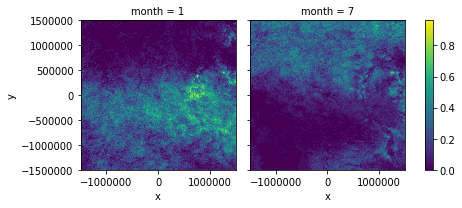

In [25]:
%matplotlib inline
res.plot(x="x", y="y", col="month")